In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy.integrate import solve_ivp
import pickle
from pathlib import Path
from tqdm import tqdm
plt.style.use('dark_background')

from kcm.dynamical_systems import create_one_dimensional_dataset
from kcm.dynamical_systems import (
    harmonic_oscillator, harmonic_params,
    sm_damper_forcing, spring_mass_forcing_params,
    duffing_oscillator, duffing_params,
    van_der_pol, vdp_params,
    nonlinear_damped_oscillator, nonlinear_damped_params,
    nonlinear_spring, nonlinear_spring_params,
    piecewise_linear_oscillator, piecewise_linear_params,
    sine_pendulum, sine_pendulum_params,
    sigmoid_pendulum, sigmoid_pendulum_params,
    arctangent_oscillator, arctangent_oscillator_params
)

In [2]:
header = {
    "seed": 42,
    "scipy_version": scipy.__version__,
    "numpy_version": np.__version__,
}
header

{'seed': 42, 'scipy_version': '1.15.3', 'numpy_version': '2.2.6'}

Things to consider:
- Each equation has several parameters that can be adjusted to create different behavior
- The initial condition governs some of the differences between different systems

## Dynamical Systems

In [3]:
systems = {
    'harmonic_oscillator' : (harmonic_oscillator, harmonic_params),
    'spring_mass_with_forcing' : (sm_damper_forcing, spring_mass_forcing_params),
    'duffing_oscillator' : (duffing_oscillator, duffing_params),
    'van_der_pol_oscillator' : (van_der_pol, vdp_params),
    'nonlinear_damped_oscillator' : (nonlinear_damped_oscillator, nonlinear_damped_params),
    'nonlinear_spring' : (nonlinear_spring, nonlinear_spring_params),
    'piecewise_linear_oscillator' : (piecewise_linear_oscillator, piecewise_linear_params),
    'sine_pendulum' : (sine_pendulum, sine_pendulum_params),
    'sigmoid_pendulum' : (sigmoid_pendulum, sigmoid_pendulum_params),
    'arctangent_oscillator' : (arctangent_oscillator, arctangent_oscillator_params),
    # 'time_varying_harmonic' : (time_varying_harmonic, time_varying_harmonic_params)
}

In [16]:
n = 5000
begin = 0
end = 50
num_series = 500
noise_multiplier = 0.01
seed = header['seed']

dataset = create_one_dimensional_dataset(n,systems,begin,end,num_series,noise_multiplier,seed=seed)

arctangent_oscillator: 100%|█████████████████████████████████████████████████████████| 500/500 [01:15<00:00,  6.65it/s]


In [17]:
save_dataset = False

if save_dataset:
    print('Saving dataset...')
    sample_name = f'noisy_{noise_multiplier}_samples' if noise_multiplier > 0 else 'samples'
    path = Path().resolve().parents[0] / 'data' / '1-dimensional-systems' / f"dataset_{len(systems)}_class_{num_series}_{sample_name}.pkl"
    
    with open(path, 'wb') as f:
        pickle.dump(dataset, f)

else:
    print('Not saving dataset')

Saving dataset...


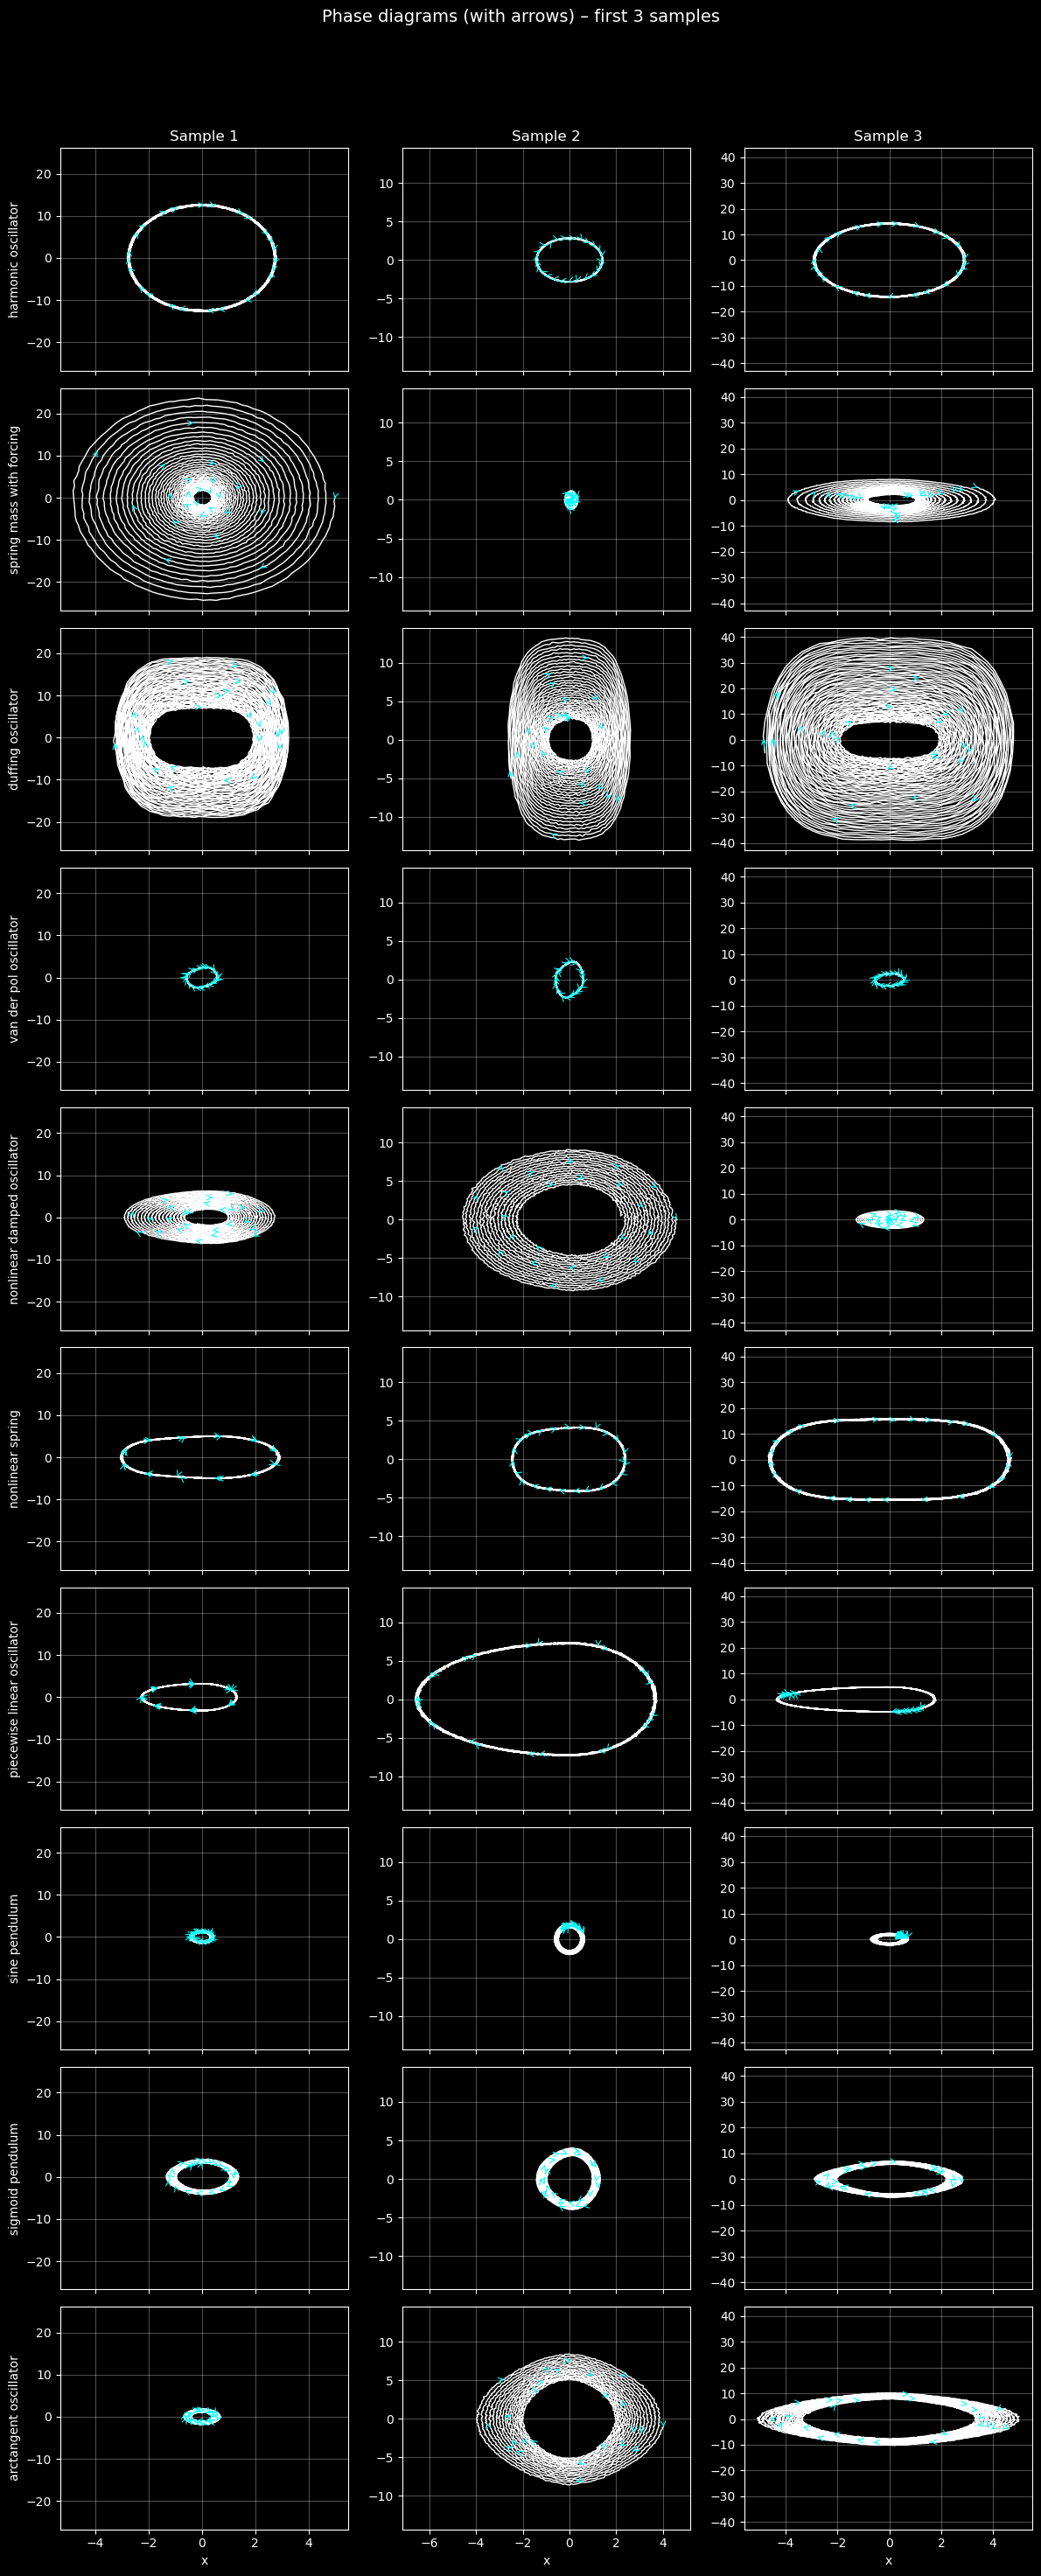

In [18]:
n_examples = 3                          # first N samples of each system
skip       = 200                         # draw an arrow every `skip` points
systems_enum    = list(dataset.keys())
rows, cols = len(systems_enum), n_examples
fig, axes  = plt.subplots(rows, cols,
                          figsize=(4*cols, 3*rows),
                          sharex='col', sharey='col')
fig.suptitle(f'Phase diagrams (with arrows) – first {n_examples} samples', fontsize=14)

for r, sys in enumerate(systems_enum):
    records = dataset[sys][:n_examples]

    for c, rec in enumerate(records):
        x, v = rec['y']                        # position & velocity
        ax   = axes[r, c] if rows > 1 else axes[c]

        # main trajectory line
        ax.plot(x, v, lw=1, color='white')

        # add arrows along the trajectory
        for j in range(0, len(x) - 1, skip):
            ax.annotate("",
                        xy=(x[j + 1], v[j + 1]),
                        xytext=(x[j], v[j]),
                        arrowprops=dict(arrowstyle="->",
                                        color="cyan",
                                        lw=0.8))

        # labels / titles
        if c == 0:
            ax.set_ylabel(sys.replace('_', ' '), fontsize=10)
        if r == rows - 1:
            ax.set_xlabel('x')
        if r == 0:
            ax.set_title(f'Sample {c + 1}')
        ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

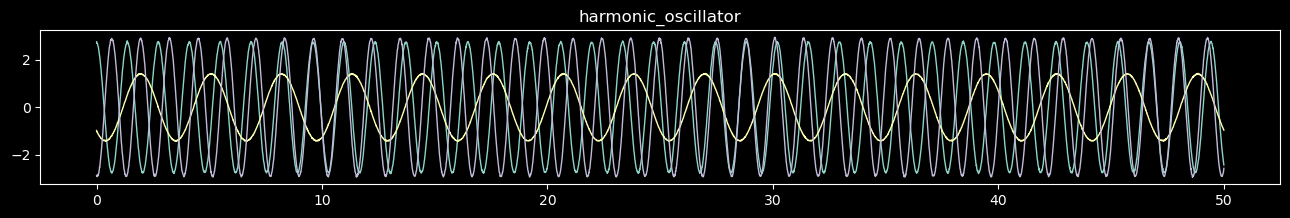

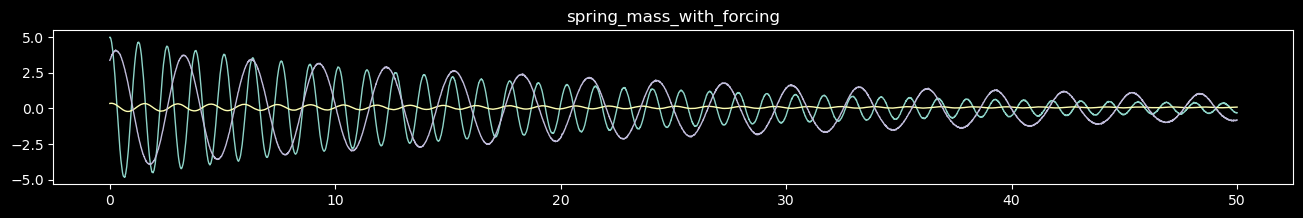

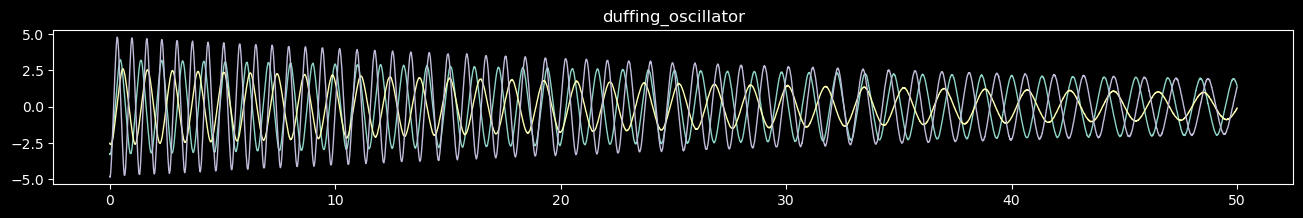

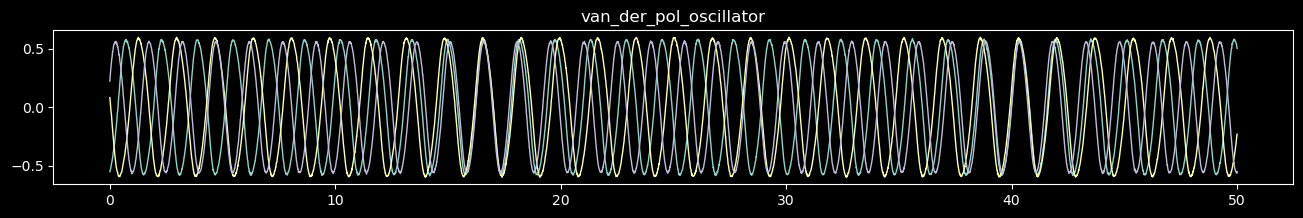

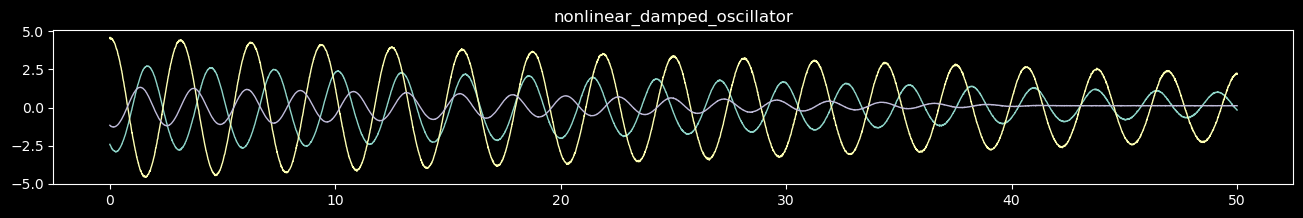

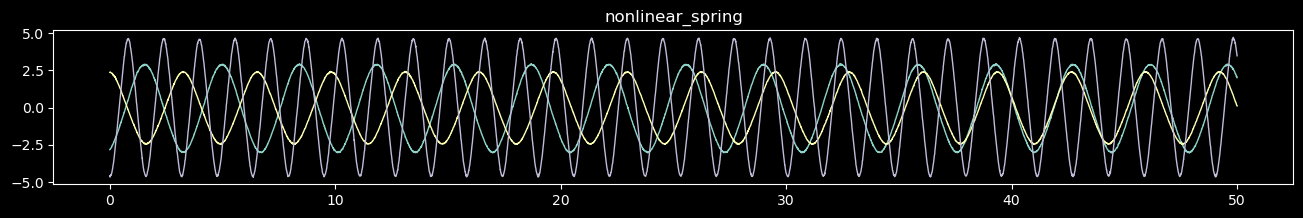

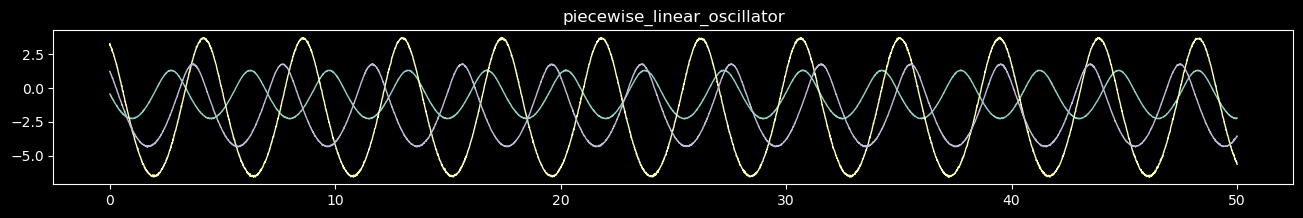

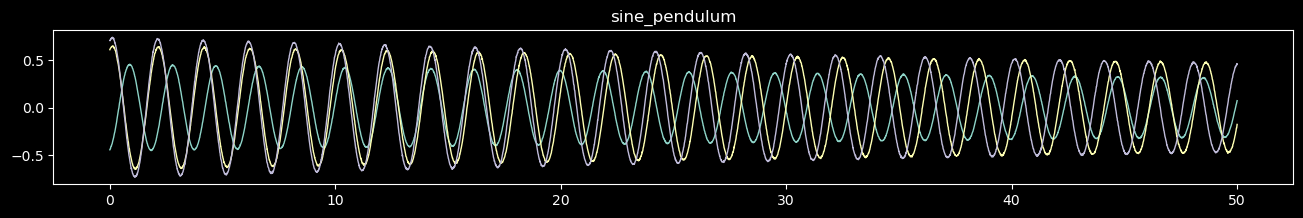

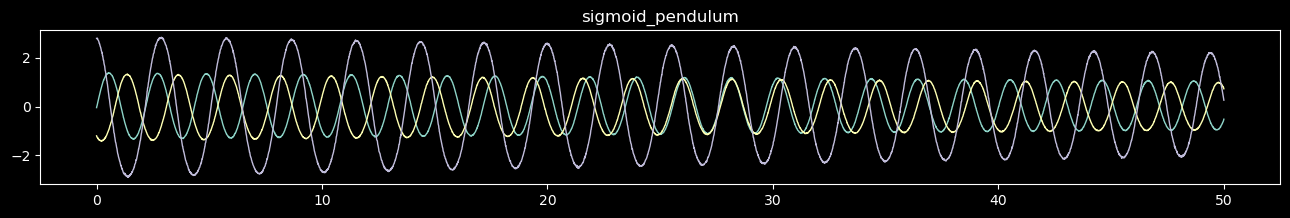

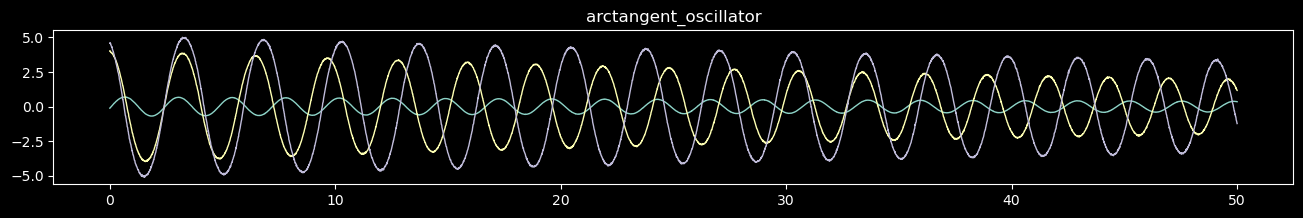

In [19]:
for key in dataset.keys():

    curr_data = dataset[key]
    
    plt.figure(figsize=(16,2))
    for i in range(3):
        x = curr_data[i]['t']
        y = curr_data[i]['y'][0,:].T
        plt.plot(x,y,linewidth=1)

    plt.title(key)
    # plt.legend(['x','v'])
    plt.show()